In [227]:
import gc
import os
import time
import warnings
from tqdm import tqdm
from typing import List, Optional

#import shap
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import f1_score as f1 
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import missingno as msno
from bayes_opt import BayesianOptimization
warnings.simplefilter("ignore")
pd.set_option("display.max_columns", 100)

In [228]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "sample_data"
    data = pd.read_csv(f"{base_path}/{data_path}", delimiter=';', decimal='.')
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data



def create_hot_one_encoded_features(X: pd.DataFrame, categorical = None):
    """
    Кодирование текстовых переменных с помощью One-Hot-Encoding.

    Parameters
    ----------
    X: pandas.DataFrame
        Сырые данные;

    categorical: List[str], optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, равен None.

    Returns
    -------
    encoded_features: pandas.DataFrame
        Матрица OHE - признаков.

    """
    encoded_features = pd.get_dummies(X[categorical])
    categorical_column_names = [col.lower().replace(" ", "_")
                                for col in encoded_features.columns]
    encoded_features.columns = categorical_column_names

    return encoded_features, categorical_column_names


def prepare_data_for_fit(X: pd.DataFrame):
    """
    Подготовка данных для обучения: разбиение данных на обучающую
    часть (где есть значения целевой переменной) и тестовую часть (где
    таких значений нет), удаление ненужных признаков для обучения и
    выявление категориальных переменных.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения алгоритма.

    x_test: pandas.core.frame.DataFrame
        Матрица признаков для предсказания алгоритма.

    target: pandas.core.frame.Series
        Вектор целевой переменной.
    """
    
    #--------------------------------------------------------------------------------------------------------------------
    mask = data["data_type"] == 'TRAIN'
    train, test = data.loc[mask], data.loc[~mask]
    
    #Вычисление кол-ва обоих классов и выяснение необходимости балансировки
    mask = train["policy_is_renewed"] == 0
    class0, class1 = train.loc[~mask], train.loc[mask]
    len_class0 = len(class0)
    len_class1 = len(class1)
    must_balance = (len_class1/(len_class0 + len_class1) > 10) 
    
    target = train["policy_is_renewed"]
    test_id = test['policy_id']
    categorical = train.dtypes[train.dtypes == "object"].index
    to_drop = ["policy_id","policy_is_renewed"]
    
    train = train.drop(categorical, axis=1)
    test = test.drop(categorical, axis=1)
    
    train = train.drop(
        to_drop, axis=1
    )
    test = test.drop(
        to_drop, axis=1
    )
    return train, test, target, must_balance, test_id

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [229]:
data = get_input('data.txt')

data.txt: shape = 96605 rows, 30 cols


In [230]:
data.head()

,data_type,policy_id,policy_begin_month,policy_end_month,policy_is_renewed,policy_sales_channel,policy_sales_channel_group,policy_branch,policy_min_age,policy_min_driving_experience,vehicle_make,vehicle_model,vehicle_engine_power,vehicle_in_credit,vehicle_sum_insured,policy_intermediary,insurer_gender,policy_clm_n,policy_clm_glt_n,policy_prv_clm_n,policy_prv_clm_glt_n,client_has_dago,client_has_osago,policy_court_sign,claim_avg_acc_st_prd,policy_has_complaints,policy_years_renewed_n,policy_deduct_value,client_registration_region,policy_price_change
0,TRAIN,1,1,1,1,39,1,Москва,51,12,Land Rover,Discovery,245.0,0,1283202.0,856,F,0,0,N,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,Opel,Zafira,140.0,0,453000.0,N,M,0,0,0,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,Kia,Soul,129.0,0,647718.0,N,F,0,0,1L,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,Citroen,C-Crosser,170.0,0,757795.0,N,M,0,0,0,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,Renault,Logan,102.0,0,604500.0,171,F,0,0,N,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


Исследование данных

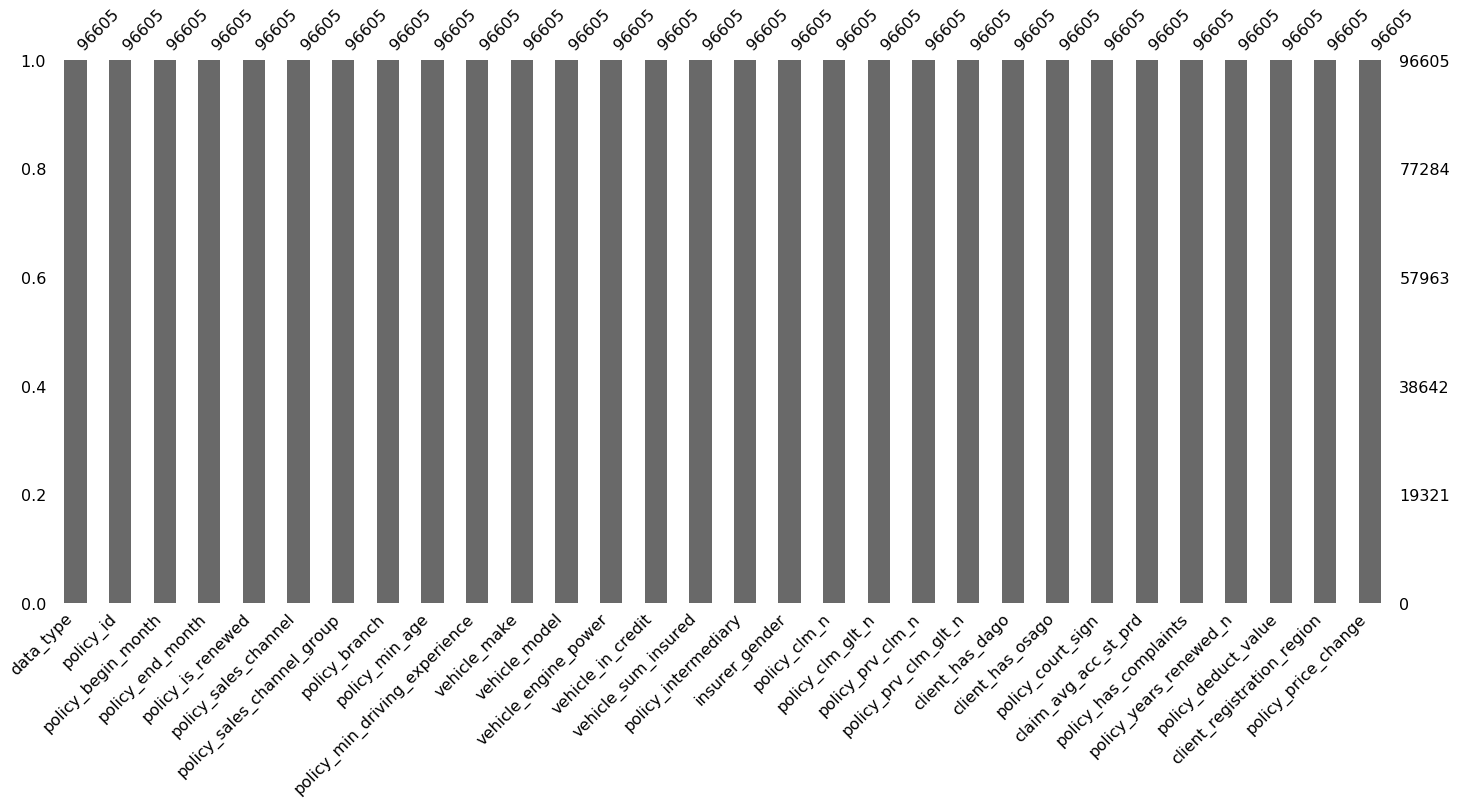

In [231]:
msno.bar(data)

Пропусков нет!

In [232]:
data.dtypes

data_type                         object
policy_id                          int64
policy_begin_month                 int64
policy_end_month                   int64
policy_is_renewed                  int64
policy_sales_channel               int64
policy_sales_channel_group         int64
policy_branch                     object
policy_min_age                     int64
policy_min_driving_experience      int64
vehicle_make                      object
vehicle_model                     object
vehicle_engine_power             float64
vehicle_in_credit                  int64
vehicle_sum_insured              float64
policy_intermediary               object
insurer_gender                    object
policy_clm_n                      object
policy_clm_glt_n                  object
policy_prv_clm_n                  object
policy_prv_clm_glt_n              object
client_has_dago                    int64
client_has_osago                   int64
policy_court_sign                  int64
claim_avg_acc_st

In [233]:
data.describe(include=[np.number])

,policy_id,policy_begin_month,policy_end_month,policy_is_renewed,policy_sales_channel,policy_sales_channel_group,policy_min_age,policy_min_driving_experience,vehicle_engine_power,vehicle_in_credit,vehicle_sum_insured,client_has_dago,client_has_osago,policy_court_sign,claim_avg_acc_st_prd,policy_has_complaints,policy_deduct_value,policy_price_change
count,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,9.660500e+04,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000,96605.000000
mean,48303.000000,6.891393,6.870400,0.500761,47.345251,5.123265,42.580767,34.910357,154.195851,0.321950,9.806700e+05,0.277480,0.550303,0.001014,3.877110,0.007660,5974.134461,-0.033025
std,27887.605715,3.400597,3.403665,0.500002,14.034159,1.585213,10.694670,199.928966,54.117543,0.467226,6.900919e+05,0.447758,0.497466,0.031834,17.635091,0.087186,10418.697183,0.857995
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,24152.000000,4.000000,4.000000,0.000000,50.000000,5.000000,34.000000,8.000000,123.000000,0.000000,5.584960e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.170000
50%,48303.000000,7.000000,7.000000,1.000000,52.000000,6.000000,41.000000,14.000000,146.000000,0.000000,8.090000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,72454.000000,10.000000,10.000000,1.000000,53.000000,6.000000,50.000000,19.000000,171.000000,1.000000,1.163900e+06,1.000000,1.000000,0.000000,0.000000,0.000000,10000.000000,0.050000
max,96605.000000,12.000000,12.000000,1.000000,63.000000,8.000000,86.000000,2015.000000,2000.000000,1.000000,9.449000e+06,1.000000,1.000000,1.000000,737.000000,1.000000,120873.000000,60.020000


In [234]:
data.describe(include=[np.object])

,data_type,policy_branch,vehicle_make,vehicle_model,policy_intermediary,insurer_gender,policy_clm_n,policy_clm_glt_n,policy_prv_clm_n,policy_prv_clm_glt_n,policy_years_renewed_n,client_registration_region
count,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605
unique,2,2,83,549,1406,2,7,7,7,7,12,85
top,TRAIN,Москва,Kia,RAV4,N,M,0,0,0,0,0,Санкт-Петербург
freq,77407,50697,11050,4186,20630,61044,68111,72295,44587,48153,33249,38854


Обработка категориальных переменных

In [235]:
data['policy_branch'].unique()

array(['Москва', 'Санкт-Петербург'], dtype=object)

In [236]:
data['Moskow'] = pd.get_dummies(data["policy_branch"])['Москва']

In [237]:
data['Peterburg'] = pd.get_dummies(data["policy_branch"])['Санкт-Петербург']

In [238]:
data = data.drop('policy_branch', axis=1)

In [239]:
data['insurer_gender'].unique()

array(['F', 'M'], dtype=object)

In [240]:
data['F'] = pd.get_dummies(data["insurer_gender"])['F']

In [241]:
data['M'] = pd.get_dummies(data["insurer_gender"])['M']

In [242]:
data = data.drop('insurer_gender', axis=1)

In [243]:
data['policy_clm_n'].unique()

array(['0', '1S', '2', '1L', '3', '4+', 'n/d'], dtype=object)

In [244]:
data['0'] = pd.get_dummies(data["policy_clm_n"])['0']

In [245]:
data['1S'] = pd.get_dummies(data["policy_clm_n"])['1S']

In [246]:
data['2'] = pd.get_dummies(data["policy_clm_n"])['2']

In [247]:
data['1L'] = pd.get_dummies(data["policy_clm_n"])['1L']

In [248]:
data['3'] = pd.get_dummies(data["policy_clm_n"])['3']

In [249]:
data['4+'] = pd.get_dummies(data["policy_clm_n"])['4+']

In [250]:
data = data.drop('policy_clm_n', axis=1)

In [251]:
data['policy_clm_glt_n'].unique()

array(['0', '1S', '2', '1L', '4+', '3', 'n/d'], dtype=object)

In [252]:
data['0_glt'] = pd.get_dummies(data["policy_clm_glt_n"])['0']

In [253]:
data['1S_glt'] = pd.get_dummies(data["policy_clm_glt_n"])['1S']

In [254]:
data['2_glt'] = pd.get_dummies(data["policy_clm_glt_n"])['2']

In [255]:
data['1L_glt'] = pd.get_dummies(data["policy_clm_glt_n"])['1L']

In [256]:
data['3_glt'] = pd.get_dummies(data["policy_clm_glt_n"])['3']

In [257]:
data['4+_glt'] = pd.get_dummies(data["policy_clm_glt_n"])['4+']

In [258]:
data = data.drop('policy_clm_glt_n', axis=1)

In [259]:
data['policy_prv_clm_n'].unique()

array(['N', '0', '1L', '1S', '2', '3', '4+'], dtype=object)

In [260]:
data['prv_0'] = pd.get_dummies(data["policy_prv_clm_n"])['0']

In [261]:
data['prv_1S'] = pd.get_dummies(data["policy_prv_clm_n"])['1S']

In [262]:
data['prv_2'] = pd.get_dummies(data["policy_prv_clm_n"])['2']

In [263]:
data['prv_1L'] = pd.get_dummies(data["policy_prv_clm_n"])['1L']

In [264]:
data['prv_3'] = pd.get_dummies(data["policy_prv_clm_n"])['3']

In [265]:
data['prv_4+'] = pd.get_dummies(data["policy_prv_clm_n"])['4+']

In [266]:
data = data.drop('policy_prv_clm_n', axis=1)

In [267]:
data['policy_prv_clm_glt_n'].unique()

array(['N', '0', '1L', '1S', '2', '3', '4+'], dtype=object)

In [268]:
data['prv_0_glt'] = pd.get_dummies(data["policy_prv_clm_glt_n"])['0']

In [269]:
data['prv_1S_glt'] = pd.get_dummies(data["policy_prv_clm_glt_n"])['1S']

In [270]:
data['prv_2_glt'] = pd.get_dummies(data["policy_prv_clm_glt_n"])['2']

In [271]:
data['prv_1L_glt'] = pd.get_dummies(data["policy_prv_clm_glt_n"])['1L']

In [272]:
data['prv_3_glt'] = pd.get_dummies(data["policy_prv_clm_glt_n"])['3']

In [273]:
data['prv_4+_glt'] = pd.get_dummies(data["policy_prv_clm_glt_n"])['4+']

In [274]:
data = data.drop('policy_prv_clm_glt_n', axis=1)

In [275]:
data['policy_years_renewed_n'].unique()

array(['0', '4', '1', '6', '3', '2', '7', '5', '10', '8', 'N', '9'],
      dtype=object)

In [276]:
### YOUR CODE HERE ###
def string_to_number(years):
    if years == 'N':
        return 0
    else:
        return int(years)

data["int_policy_years_renewed_n"] = data.apply(lambda x: string_to_number(x['policy_years_renewed_n']),axis=1)

In [277]:
data = data.drop('policy_years_renewed_n', axis=1)

In [278]:
data.head(2)

,data_type,policy_id,policy_begin_month,policy_end_month,policy_is_renewed,policy_sales_channel,policy_sales_channel_group,policy_min_age,policy_min_driving_experience,vehicle_make,vehicle_model,vehicle_engine_power,vehicle_in_credit,vehicle_sum_insured,policy_intermediary,client_has_dago,client_has_osago,policy_court_sign,claim_avg_acc_st_prd,policy_has_complaints,policy_deduct_value,client_registration_region,policy_price_change,Moskow,Peterburg,F,M,0,1S,2,1L,3,4+,0_glt,1S_glt,2_glt,1L_glt,3_glt,4+_glt,prv_0,prv_1S,prv_2,prv_1L,prv_3,prv_4+,prv_0_glt,prv_1S_glt,prv_2_glt,prv_1L_glt,prv_3_glt,prv_4+_glt,int_policy_years_renewed_n
0,TRAIN,1,1,1,1,39,1,51,12,Land Rover,Discovery,245.0,0,1283202.0,856,1,0,0,0.0,0,0.0,Тульская,-1.00,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,TRAIN,2,1,1,1,50,5,35,7,Opel,Zafira,140.0,0,453000.0,N,1,1,0,0.0,0,0.0,Москва,-0.05,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4


In [279]:
#имеет смысл новый параметр частотность марки ТС
freq_encoder = data["vehicle_make"].value_counts(normalize=True)
data["vehicle_make_freq_enc"] = data["vehicle_make"].map(freq_encoder)
data[["vehicle_make", "vehicle_make_freq_enc"]].head(2)

,vehicle_make,vehicle_make_freq_enc
0,Land Rover,0.017328
1,Opel,0.018519


In [280]:
data["vehicle_model"] = data["vehicle_make"] + ' ' + data["vehicle_model"] 

In [281]:
#имеет смысл новый параметр частотность модели ТС
freq_encoder = data["vehicle_model"].value_counts(normalize=True)
data["vehicle_model_freq_enc"] = data["vehicle_model"].map(freq_encoder)
data[["vehicle_model", "vehicle_model_freq_enc"]].head(2)

,vehicle_model,vehicle_model_freq_enc
0,Land Rover Discovery,0.002733
1,Opel Zafira,0.001936


In [282]:
data.head(2)

,data_type,policy_id,policy_begin_month,policy_end_month,policy_is_renewed,policy_sales_channel,policy_sales_channel_group,policy_min_age,policy_min_driving_experience,vehicle_make,vehicle_model,vehicle_engine_power,vehicle_in_credit,vehicle_sum_insured,policy_intermediary,client_has_dago,client_has_osago,policy_court_sign,claim_avg_acc_st_prd,policy_has_complaints,policy_deduct_value,client_registration_region,policy_price_change,Moskow,Peterburg,F,M,0,1S,2,1L,3,4+,0_glt,1S_glt,2_glt,1L_glt,3_glt,4+_glt,prv_0,prv_1S,prv_2,prv_1L,prv_3,prv_4+,prv_0_glt,prv_1S_glt,prv_2_glt,prv_1L_glt,prv_3_glt,prv_4+_glt,int_policy_years_renewed_n,vehicle_make_freq_enc,vehicle_model_freq_enc
0,TRAIN,1,1,1,1,39,1,51,12,Land Rover,Land Rover Discovery,245.0,0,1283202.0,856,1,0,0,0.0,0,0.0,Тульская,-1.00,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.017328,0.002733
1,TRAIN,2,1,1,1,50,5,35,7,Opel,Opel Zafira,140.0,0,453000.0,N,1,1,0,0.0,0,0.0,Москва,-0.05,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,4,0.018519,0.001936


Разбивка данных на train и test

In [283]:
data['data_type'].unique()

array(['TRAIN', 'TEST '], dtype=object)

In [284]:
train, test, target, must_balance, test_id = prepare_data_for_fit(data)

numerical_features = train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

count of numeric_features 47


выяснение необходимости балансировки

In [285]:
print(must_balance)

False


In [286]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=27
)


print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 54184 rows, 47 cols
x_valid.shape = 23223 rows, 47 cols


Случайный лес (Random Forest)

In [287]:
for i in range(35,30,-1):
    print(f'max_depth={i}')
    clf = RF(max_depth=i, n_estimators=40, max_features=4, random_state=100)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_train)
    print(f1(y_train,pred, average='macro'))
    pred_valid = clf.predict(x_valid)
    print(f1(y_valid,pred_valid, average='macro'))
    print()

max_depth=35
0.9997246282474079
0.6422277270745904

max_depth=34
0.9996065964019457
0.6412022467491112

max_depth=33
0.9995278787493924
0.6452824260736217

max_depth=32
0.9994491810971299
0.6440380250634591

max_depth=31
0.9988390161235373
0.6436446924708359



In [288]:
clf = RF(max_depth=33,n_estimators=40,max_features=4,random_state=100)

In [289]:
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=33, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=100, verbose=0, warm_start=False)

In [290]:
pred = clf.predict(x_train)

In [291]:
f1(y_train, pred, average='macro')

0.9995278787493924

In [292]:
pred_valid = clf.predict(x_valid)

In [293]:
f1(y_valid,pred_valid, average='macro')

0.6452824260736217

In [294]:
get_classification_report(y_train, pred, y_valid, pred_valid)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20368
           1       1.00      1.00      1.00     33816

   micro avg       1.00      1.00      1.00     54184
   macro avg       1.00      1.00      1.00     54184
weighted avg       1.00      1.00      1.00     54184

TEST

              precision    recall  f1-score   support

           0       0.64      0.42      0.51      8663
           1       0.71      0.86      0.78     14560

   micro avg       0.70      0.70      0.70     23223
   macro avg       0.68      0.64      0.65     23223
weighted avg       0.69      0.70      0.68     23223

CONFUSION MATRIX

col_0                 0      1
policy_is_renewed             
0                  3644   5019
1                  2006  12554


In [295]:
oof_preds_rf = roc_auc_score(y_valid, pred_valid) 
oof_preds_rf

0.6414323880263797

XGBoost

In [296]:
%%time

#clf = xgb.XGBClassifier(max_depth=28, objective='multi:softmax', n_estimators=40)

clf = xgb.XGBClassifier()

clf.fit(x_train, y_train)

Wall time: 3.22 s


In [297]:
pred = clf.predict(x_train)

In [298]:
f1(y_train, pred, average='macro')

0.745823894808324

In [299]:
pred_valid = clf.predict(x_valid)

In [300]:
f1(y_valid,pred_valid, average='macro')

0.6708921609308578

In [301]:
get_classification_report(y_train, pred, y_valid, pred_valid)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.54      0.65     20368
           1       0.77      0.92      0.84     33816

   micro avg       0.78      0.78      0.78     54184
   macro avg       0.79      0.73      0.75     54184
weighted avg       0.79      0.78      0.77     54184

TEST

              precision    recall  f1-score   support

           0       0.68      0.46      0.55      8663
           1       0.73      0.87      0.79     14560

   micro avg       0.72      0.72      0.72     23223
   macro avg       0.70      0.66      0.67     23223
weighted avg       0.71      0.72      0.70     23223

CONFUSION MATRIX

col_0                 0      1
policy_is_renewed             
0                  3973   4690
1                  1878  12682


In [302]:
pred_valid = clf.predict(x_valid)

In [303]:
oof_preds_xgb = roc_auc_score(y_valid, pred_valid)
oof_preds_xgb

0.6648167953770805

In [304]:
%%time

params = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": 27
}

dtrain = xgb.DMatrix(
    x_train, y_train
)
dvalid = xgb.DMatrix(
    x_valid, y_valid
)

model = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
    early_stopping_rounds=25,
    num_boost_round=1000,
    verbose_eval=10,
    maximize=True,
)

[0]	dtrain-auc:0.70829	dvalid-auc:0.70906
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.71279	dvalid-auc:0.71380
[20]	dtrain-auc:0.71438	dvalid-auc:0.71509
[30]	dtrain-auc:0.71565	dvalid-auc:0.71633
[40]	dtrain-auc:0.71639	dvalid-auc:0.71743
[50]	dtrain-auc:0.71852	dvalid-auc:0.71897
[60]	dtrain-auc:0.71996	dvalid-auc:0.71987
[70]	dtrain-auc:0.72267	dvalid-auc:0.72172
[80]	dtrain-auc:0.72505	dvalid-auc:0.72349
[90]	dtrain-auc:0.72677	dvalid-auc:0.72435
[100]	dtrain-auc:0.72862	dvalid-auc:0.72537
[110]	dtrain-auc:0.73012	dvalid-auc:0.72636
[120]	dtrain-auc:0.73211	dvalid-auc:0.72756
[130]	dtrain-auc:0.73405	dvalid-auc:0.72880
[140]	dtrain-auc:0.73608	dvalid-auc:0.72997
[150]	dtrain-auc:0.73776	dvalid-auc:0.73093
[160]	dtrain-auc:0.73926	dvalid-auc:0.73169
[170]	dtrain-auc:0.74056	dvalid-auc:0.73237
[180]	dtrain-auc:0.74187	dvalid-auc:0.73309
[190]	dtrain-auc:0.74306	dvali

In [305]:
pred = model.predict(dtrain)

In [306]:
pred_valid = model.predict(dvalid)

In [307]:
y_valid

13569    1
4669     0
47370    0
43200    1
92762    0
        ..
14971    1
61113    0
21953    1
48934    1
69142    1
Name: policy_is_renewed, Length: 23223, dtype: int64

In [308]:
pred_valid

array([0.7268616 , 0.5513178 , 0.6443973 , ..., 0.4264992 , 0.68362355,
       0.51716423], dtype=float32)

In [309]:
pred_valid_2 = [] 
for i in pred_valid:
    if i > 0.5:
        pred_valid_2.append(1)
    else:
        pred_valid_2.append(0) 
pred_valid_2 = np.array(pred_valid_2)

        

In [310]:
f1(y_valid,pred_valid_2, average='macro')

0.6688338613287934

In [311]:
oof_preds_xgb = roc_auc_score(y_valid, pred_valid)
oof_preds_xgb

0.7447107297931206

Оптимизация гиперпараметров

In [312]:
def xgboost_optimize_params(max_depth, min_child_weights, colsample_bytree):

    params["max_depth"] = int(max_depth)
    params["min_child_weights"] = int(min_child_weights)
    params["colsample_bytree"] = colsample_bytree

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
        early_stopping_rounds=25,
        num_boost_round=1000,
        verbose_eval=10,
        maximize=True,
    )

    return roc_auc_score(y_valid, model.predict(dvalid))

In [313]:
params_search = {
    "max_depth": (3, 8),
    "min_child_weights": (5, 500),
    "colsample_bytree": (0.3, 0.9)
}

xgb_params_search = BayesianOptimization(
    xgboost_optimize_params,
    pbounds=params_search,
    random_state=27
)
xgb_params_search.maximize(
    init_points=3, n_iter=5, acq='ei'
)

|   iter    |  target   | colsam... | max_depth | min_ch... |
-------------------------------------------------------------
[01:24:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	dtrain-auc:0.71003	dvalid-auc:0.70460
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.73933	dvalid-auc:0.72792
[20]	dtrain-auc:0.73945	dvalid-auc:0.72871
[30]	dtrain-auc:0.74240	dvalid-auc:0.73010
[40]	dtrain-auc:0.74433	dvalid-auc:0.73090
[50]	dtrain-auc:0.74576	dvalid-auc:0.73201
[60]	dtrain-auc:0.74695	dvalid-auc:0.73288
[70]	dtrain-auc:0.74879	dvalid-auc:0

[570]	dtrain-auc:0.74199	dvalid-auc:0.73707
[580]	dtrain-auc:0.74226	dvalid-auc:0.73725
[590]	dtrain-auc:0.74261	dvalid-auc:0.73745
[600]	dtrain-auc:0.74289	dvalid-auc:0.73762
[610]	dtrain-auc:0.74324	dvalid-auc:0.73777
[620]	dtrain-auc:0.74355	dvalid-auc:0.73788
[630]	dtrain-auc:0.74379	dvalid-auc:0.73804
[640]	dtrain-auc:0.74407	dvalid-auc:0.73822
[650]	dtrain-auc:0.74433	dvalid-auc:0.73837
[660]	dtrain-auc:0.74463	dvalid-auc:0.73854
[670]	dtrain-auc:0.74489	dvalid-auc:0.73870
[680]	dtrain-auc:0.74518	dvalid-auc:0.73884
[690]	dtrain-auc:0.74541	dvalid-auc:0.73896
[700]	dtrain-auc:0.74569	dvalid-auc:0.73907
[710]	dtrain-auc:0.74592	dvalid-auc:0.73912
[720]	dtrain-auc:0.74611	dvalid-auc:0.73923
[730]	dtrain-auc:0.74637	dvalid-auc:0.73930
[740]	dtrain-auc:0.74658	dvalid-auc:0.73936
[750]	dtrain-auc:0.74681	dvalid-auc:0.73945
[760]	dtrain-auc:0.74705	dvalid-auc:0.73953
[770]	dtrain-auc:0.74730	dvalid-auc:0.73960
[780]	dtrain-auc:0.74758	dvalid-auc:0.73970
[790]	dtrain-auc:0.74789	dvalid-

[240]	dtrain-auc:0.76828	dvalid-auc:0.74148
[250]	dtrain-auc:0.76932	dvalid-auc:0.74182
[260]	dtrain-auc:0.77028	dvalid-auc:0.74225
[270]	dtrain-auc:0.77141	dvalid-auc:0.74262
[280]	dtrain-auc:0.77224	dvalid-auc:0.74291
[290]	dtrain-auc:0.77322	dvalid-auc:0.74318
[300]	dtrain-auc:0.77424	dvalid-auc:0.74349
[310]	dtrain-auc:0.77546	dvalid-auc:0.74370
[320]	dtrain-auc:0.77618	dvalid-auc:0.74398
[330]	dtrain-auc:0.77698	dvalid-auc:0.74434
[340]	dtrain-auc:0.77785	dvalid-auc:0.74457
[350]	dtrain-auc:0.77874	dvalid-auc:0.74482
[360]	dtrain-auc:0.77947	dvalid-auc:0.74514
[370]	dtrain-auc:0.78010	dvalid-auc:0.74543
[380]	dtrain-auc:0.78080	dvalid-auc:0.74562
[390]	dtrain-auc:0.78154	dvalid-auc:0.74573
[400]	dtrain-auc:0.78216	dvalid-auc:0.74590
[410]	dtrain-auc:0.78278	dvalid-auc:0.74603
[420]	dtrain-auc:0.78348	dvalid-auc:0.74616
[430]	dtrain-auc:0.78410	dvalid-auc:0.74630
[440]	dtrain-auc:0.78455	dvalid-auc:0.74644
[450]	dtrain-auc:0.78511	dvalid-auc:0.74662
[460]	dtrain-auc:0.78566	dvalid-

In [314]:
optimal_xgb_params = xgb_params_search.max
optimal_xgb_params

{'target': 0.7492981828427834,
 'params': {'colsample_bytree': 0.5554328463113375,
  'max_depth': 7.072918702472763,
  'min_child_weights': 369.0216586488414}}

In [315]:
%%time

params = {
    "booster": "gbtree",
    "eval_metric": "auc",
    "objective": "binary:logistic",
    "learning_rate": 0.01,
    "nthread": 6,
    "seed": 27,
    "colsample_bytree": 0.6,
    'max_depth': 7
}

dtrain = xgb.DMatrix(
    x_train, y_train
)
dvalid = xgb.DMatrix(
    x_valid, y_valid
)

model_opt = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
    early_stopping_rounds=25,
    num_boost_round=1000,
    verbose_eval=10,
    maximize=True,
)

[0]	dtrain-auc:0.71018	dvalid-auc:0.70446
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.73948	dvalid-auc:0.72755
[20]	dtrain-auc:0.73982	dvalid-auc:0.72831
[30]	dtrain-auc:0.74258	dvalid-auc:0.73027
[40]	dtrain-auc:0.74430	dvalid-auc:0.73107
[50]	dtrain-auc:0.74546	dvalid-auc:0.73214
[60]	dtrain-auc:0.74657	dvalid-auc:0.73282
[70]	dtrain-auc:0.74856	dvalid-auc:0.73356
[80]	dtrain-auc:0.74936	dvalid-auc:0.73419
[90]	dtrain-auc:0.75041	dvalid-auc:0.73450
[100]	dtrain-auc:0.75106	dvalid-auc:0.73487
[110]	dtrain-auc:0.75216	dvalid-auc:0.73536
[120]	dtrain-auc:0.75371	dvalid-auc:0.73557
[130]	dtrain-auc:0.75512	dvalid-auc:0.73639
[140]	dtrain-auc:0.75658	dvalid-auc:0.73696
[150]	dtrain-auc:0.75756	dvalid-auc:0.73755
[160]	dtrain-auc:0.75877	dvalid-auc:0.73815
[170]	dtrain-auc:0.75984	dvalid-auc:0.73861
[180]	dtrain-auc:0.76075	dvalid-auc:0.73937
[190]	dtrain-auc:0.76193	dvali

In [316]:
pred_valid = model_opt.predict(dvalid)

In [317]:
pred_valid_2 = [] 
for i in pred_valid:
    if i > 0.5:
        pred_valid_2.append(1)
    else:
        pred_valid_2.append(0) 
pred_valid_2 = np.array(pred_valid_2)
        

In [318]:
f1(y_valid,pred_valid_2, average='macro')

0.6707550552926693

In [319]:
oof_preds_xgb = roc_auc_score(y_valid, pred_valid)
oof_preds_xgb

0.749064834435448

In [320]:
y_pred_xgb = np.zeros(test.shape[0])
#test = test.astype(float)
dtest = xgb.DMatrix(test)

y_pred_xgb += model_opt.predict(dtest)

In [325]:
y_pred_xgb

array([0.8476997 , 0.71479642, 0.59802598, ..., 0.89758897, 0.71679354,
       0.8360526 ])

In [328]:
policy_is_renewed = [] 
for i in y_pred_xgb:
    if i > 0.5:
        policy_is_renewed.append(1)
    else:
        policy_is_renewed.append(0) 
policy_is_renewed = np.array(policy_is_renewed)

In [329]:
policy_is_renewed

array([1, 1, 1, ..., 1, 1, 1])

In [330]:
y_pred = pd.DataFrame({ 
    "POLICY_ID": test_id,
    "POLICY_IS_RENEWED": policy_is_renewed,
    "POLICY_IS_RENEWED_PROBABILITY": y_pred_xgb
})
y_pred.to_csv("final_result.csv",index=False)